In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from pytorch_revgrad import RevGrad

train_MNIST = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_MNIST = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

train_USPS = datasets.USPS('USPS', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test_USPS = datasets.USPS('USPS', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset_MNIST = torch.utils.data.DataLoader(train_MNIST, batch_size=32, shuffle=True)
testset_MNIST = torch.utils.data.DataLoader(test_MNIST, batch_size=32, shuffle=False)

trainset_USPS = torch.utils.data.DataLoader(train_USPS, batch_size=32, shuffle=True)
testset_USPS = torch.utils.data.DataLoader(test_USPS, batch_size=32, shuffle=False)

In [2]:
# defining the transformation

p = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.RandomCrop((28, 28)),
    transforms.ToTensor(),
])

In [3]:
# transforming the MNIST data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

train_MNIST_transformed = [] # initializing the entire (batched) dataset as an empty list

for batch_MNIST in trainset_MNIST:
        
    images = batch_MNIST[0] # taking the images from the dataset batch. this a torch.tensor of shape (32, 1, 28, 28)
    labels = batch_MNIST[1] # taking the labels from the dataset batch. 
    
    images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)
        
    for i in range(0, len(images)):
        
        image = images[i] 
        
        image_transformed = p(image) # transforming the image with predefined transformation "p"
        images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
    batch_MNIST_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
    train_MNIST_transformed.append(batch_MNIST_transformed) # appending to the empty dataset list

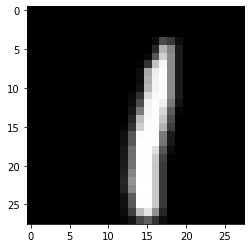

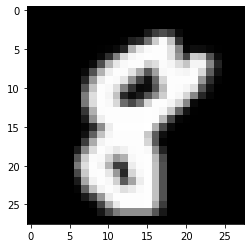

60000


In [4]:
# plotting 2 images from MNIST datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_MNIST_0 = train_MNIST_transformed[0]
images0 = batch_MNIST_0[0]
image0 = images0[0]
image1 = images0[1]

plt.imshow(image0.view(28,28), cmap="gray")
plt.show()

plt.imshow(image1.view(28,28), cmap="gray")
plt.show()

print(len(train_MNIST_transformed)*32)

In [5]:
# transforming the USPS data according to how it is done in the paper. First interpolating so that images are 32x32 and than performing 'random' 28x28 crop

train_USPS_transformed = [] # initializing the entire (batched) dataset as an empty list

for batch_USPS in trainset_USPS:
        
    images = batch_USPS[0] # taking the images from the dataset batch. this a torch.tensor of shape (32, 1, 28, 28)
    labels = batch_USPS[1] # taking the labels from the dataset batch. 
    
    images_transformed = torch.zeros(size=torch.Size([32, 1, 28, 28])) # initializing the transformed images with the same shape as images (32, 1, 28, 28)
        
    for i in range(0, len(images)):
        
        image = images[i] 
        
        image_transformed = p(image) # transforming the image with predefined transformation "p"
        images_transformed[i] = image_transformed # replacing zero tensor (1, 28, 28) in images_transformed with the transformed image
            
    batch_USPS_transformed = [images_transformed, labels] # transformed batch is simply a list of batch of images in [0] and batch of labels in [1]
    
    train_USPS_transformed.append(batch_USPS_transformed) # appending to the empty dataset list

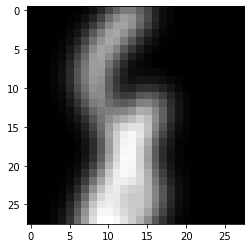

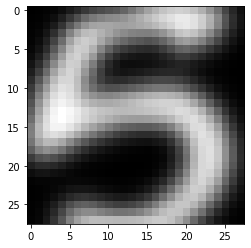

7296


In [6]:
# plotting 2 images from USPS datset (2 to make sure I didn't make a mistake in transforming the dataset)

batch_USPS_0 = train_USPS_transformed[0]

images0 = batch_USPS_0[0]
image0 = images0[0]
image1 = images0[1]

plt.imshow(image0.view(28,28), cmap="gray")
plt.show()

plt.imshow(image1.view(28,28), cmap="gray")
plt.show()

print(len(train_USPS_transformed)*32)

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from model import fNet, gNet, Discriminator, hSim, SimNet

In [8]:
def init_weights_disc(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight)
#         m.bias.data.fill_(0.01) # do we need something like this?

In [10]:
# take prototypes from MNIST (in the future they have to be chosen randomly --> shuffle?)
prototype_images = [0] * 10

for source_data in train_MNIST_transformed:
    X_source, y_source = source_data
    
    for j in range(0, len(y_source)):
        
        if torch.sum(torch.Tensor(prototype_images[int(y_source[j])])) == 0:
            prototype_images[int(y_source[j])] = X_source[j].view(1, 1, 28, 28) 

In [11]:
# for prototype_image in prototype_images:
#     print(prototype_image.shape)
#     plt.imshow(prototype_image.view(28,28), cmap="gray")
#     plt.show()

In [16]:
gamma_reg = 0.01
lambda_loss= 0.5

simnet = SimNet()
gnet = gNet()
simnet.apply(init_weights_disc)

optimizerSimNet = torch.optim.SGD(simnet.parameters(), lr=0.001, momentum=0.99, weight_decay=0.00001)

for epoch in range(3): # 3 full passes over the data
    
    num_batches = len(train_USPS_transformed)

    for i in range(0, num_batches):
        
        MNIST_batch = train_MNIST_transformed[i]
        USPS_batch = train_USPS_transformed[i]
        
        X_MNIST, y_MNIST = MNIST_batch
        X_USPS, y_USPS = USPS_batch
        
        simnet.zero_grad()
        
        prototypes = gnet.calcproto(prototype_images)
        
        Regularizer = torch.norm(torch.matmul(prototypes.t(), prototypes) - torch.eye(128))
        Regularizer = Regularizer*Regularizer
        
        [source_class_output, source_domain_output] = simnet(X_MNIST, prototype_images)
        [target_class_output, target_domain_output] = simnet(X_USPS, prototype_images)
        
        loss_class = F.nll_loss(source_class_output, y_MNIST) + gamma_reg * Regularizer
        loss_disc = - torch.sum(torch.log(source_domain_output)) - torch.sum(torch.log(1 - source_domain_output))

        total_loss = loss_class - lambda_loss * loss_disc        
        total_loss.backward()
        
        optimizerSimNet.step()
        
        print("loss_class: " + str(loss_class))
        print("loss_disc: " + str(loss_disc))

loss_class: tensor(224.5517, grad_fn=<AddBackward0>)
loss_disc: tensor(inf, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0>)
loss_disc: tensor(nan, grad_fn=<SubBackward0>)
loss_class: tensor(nan, grad_fn=<AddBackward0

In [87]:
for test_batch in testset_MNIST:
    
    X, y = test_batch
    [class_output, domain_output] = simnet(X, prototype_images)
    
#     print(domain_output)
    print(class_output)
    print(y)
    
    break

tensor([[-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026, -2.3026,
         -2.3026, -2.3026],
        [-2.3026, -